In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler,  RobustScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta
import time


# Descarga de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
carpeta = '/content/drive/My Drive/PrediccionCriptos'
archivos = os.listdir(carpeta)
print(archivos)

['ETH-1-Year-5min.parquet', 'ETH-1-Year-5min.csv', 'modelo_final.h5', 'PredecirCriptoFinal.ipynb']


In [4]:
# Error en los datos al convertir a parquet por lo que se cambio el formato a csv
# data_path = '/content/drive/My Drive/PrediccionCriptos/ETH-1-Year-5min.parquet'
# eth_df = pd.read_parquet(data_path)

data_path = '/content/drive/My Drive/PrediccionCriptos/ETH-1-Year-5min.csv'
eth_df = pd.read_csv(data_path)
eth_df.shape

(105120, 6)

# Preprocesamiento

In [5]:
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'])
eth_df.set_index('timestamp', inplace=True)

In [6]:
eth_df.head()

,open,high,low,close,volume
timestamp,,,,,
2023-05-16 03:25:00,1811.51,1812.60,1811.28,1812.36,413.6284
2023-05-16 03:30:00,1812.35,1812.91,1811.00,1812.23,618.8581
2023-05-16 03:35:00,1812.24,1813.99,1812.03,1812.85,1165.6089
2023-05-16 03:40:00,1812.85,1814.30,1812.60,1812.77,896.9234
2023-05-16 03:45:00,1812.77,1812.97,1812.38,1812.38,420.9102


# Visualización de dataset

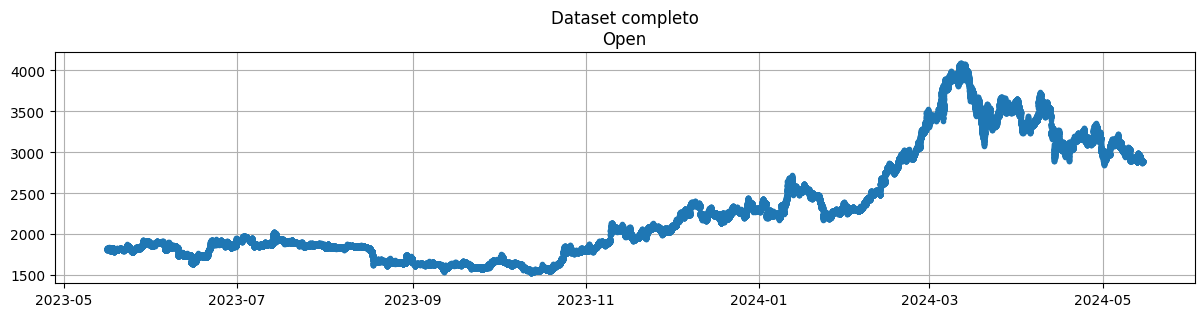

In [7]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset completo\nOpen")
ax1.plot(eth_df.high,marker='.',linewidth=0)
plt.grid(True)
plt.show()

In [8]:
eth_df.describe()

,open,high,low,close,volume
count,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000
mean,2278.030550,2280.185491,2275.757571,2278.040851,1207.255362
std,653.151755,654.492014,651.707450,653.152930,1743.006238
min,1524.220000,1526.760000,1521.000000,1524.220000,30.746300
25%,1809.800000,1810.905000,1808.565000,1809.790000,403.680200
50%,2006.190000,2007.990000,2004.085000,2006.240000,721.216900
75%,2660.600000,2664.595000,2656.732500,2660.697500,1329.880475
max,4091.810000,4093.920000,4085.720000,4091.810000,52372.648700


# Validación de periodisidad y duplicados de datos

In [9]:
duplicates = eth_df[eth_df.duplicated()]
duplicates.count()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [10]:

# Ordenar los datos
eth_df = eth_df.sort_index()

# Verificar que los intervalos sean de 5 min
intervalos_esperados = pd.date_range(start=eth_df.index.min(), end=eth_df.index.max(), freq='5T')
intervalos_faltantes = intervalos_esperados.difference(eth_df.index)
if len(intervalos_faltantes) == 0:
    print("Todos los intervalos de 5 minutos están presentes.")
else:
    print("Faltan intervalos de 5 minutos en la serie de tiempo.")

# Verificar la regularidad de los intervalos
diferencia_intervalos = eth_df.index.to_series().diff().dropna()
if (diferencia_intervalos == pd.Timedelta(minutes=5)).all():
    print("La serie de tiempo tiene intervalos regulares de 5 minutos.")
else:
    print("Error: La serie de tiempo tiene intervalos irregulares.")

Todos los intervalos de 5 minutos están presentes.
La serie de tiempo tiene intervalos regulares de 5 minutos.


In [11]:
eth_df = eth_df.sort_index()

# Calcular la diferencia de tiempo entre cada marca de tiempo
diferencia_intervalos = eth_df.index.to_series().diff().dropna()

# Encontrar las diferencias que no son de 5 minutos
intervalos_no_5min = diferencia_intervalos[diferencia_intervalos != timedelta(minutes=5)]

# Mostrar las diferencias que no cumplen con los 5 minutos
print("Intervalos que no cumplen con 5 minutos:",len(intervalos_no_5min))

Intervalos que no cumplen con 5 minutos: 0


# Creación de datasets utilizando la variable *high*

In [12]:
# Dataset de entrenamiento que toma todos los registros de 2023 de la columna high
train_ds = eth_df[:'2023'].iloc[:,1:2]

# Dataset de validacion que toma todos los registros de 2023 de la columna high
valid_ds = eth_df['2024':].iloc[:,1:2]

In [13]:
train_ds

,high
timestamp,
2023-05-16 03:25:00,1812.60
2023-05-16 03:30:00,1812.91
2023-05-16 03:35:00,1813.99
2023-05-16 03:40:00,1814.30
2023-05-16 03:45:00,1812.97
...,...
2023-12-31 23:35:00,2280.00
2023-12-31 23:40:00,2279.99
2023-12-31 23:45:00,2283.88


In [14]:
print("Tamaño del dataset de entrenamiento:", train_ds.shape[0])
print("Tamaño del dataset de validacion:", valid_ds.shape[0])

Tamaño del dataset de entrenamiento: 66199
Tamaño del dataset de validacion: 38921


## Visualización de datos de entrenamiento y de validación

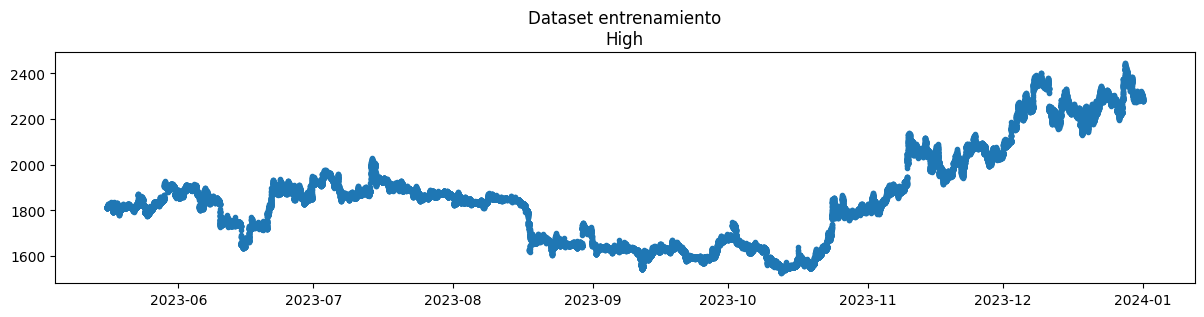

In [15]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset entrenamiento\nHigh")
ax1.plot( train_ds.high, marker = '.', linewidth = 0 )
plt.show()

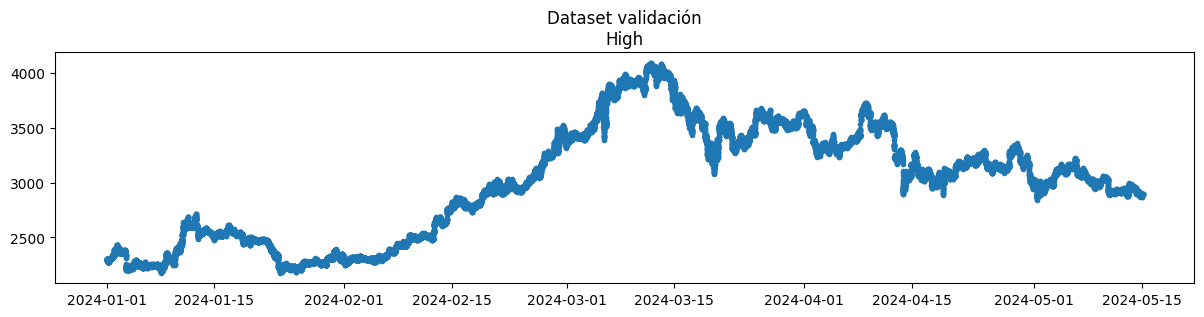

In [16]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Dataset validación\nHigh")
ax1.plot( valid_ds.high, marker = '.', linewidth = 0 )
plt.show()

# Escalación de los datos

In [ ]:
# scaler = MinMaxScaler( feature_range = (0,1) )
# train_ds_escalado = scaler.fit_transform(train_ds)

In [17]:
scaler_train = RobustScaler(quantile_range=(25, 75))
train_ds_escalado = scaler_train.fit_transform(train_ds)

In [18]:
time_step = 100  # <-------- parametro: numero de valores a usar para predecir el siguiente (100 datos)
X_train = []
Y_train = []
m = len(train_ds_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(train_ds_escalado[i-time_step:i,0])

    # Y: el siguiente dato (Ejemplo: X_train:0:100, Y_train:101)
    Y_train.append(train_ds_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [19]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

X_train: (66099, 100)
Y_train: (66099,)


In [20]:
print("X_train:",X_train[0])
print("Y_train:",Y_train[0])

X_train: [-0.12712151 -0.12595492 -0.12189064 -0.12072404 -0.12572912 -0.12682046
 -0.12332066 -0.11839085 -0.12463779 -0.12817522 -0.12742257 -0.12809995
 -0.12742257 -0.12531517 -0.12922892 -0.12411094 -0.12452489 -0.12636887
 -0.12633124 -0.12015956 -0.11842848 -0.11835322 -0.12053588 -0.12053588
 -0.12380988 -0.12666993 -0.13103526 -0.13235239 -0.13502427 -0.13092236
 -0.13133632 -0.13340609 -0.13671772 -0.13581455 -0.13735747 -0.13735747
 -0.13415873 -0.12591728 -0.12689572 -0.12900312 -0.13103526 -0.12467542
 -0.12565386 -0.12106273 -0.12151432 -0.11967034 -0.09505889 -0.09852106
 -0.10506906 -0.10439168 -0.09344071 -0.08568848 -0.08625296 -0.09178489
 -0.08918827 -0.08918827 -0.09099462 -0.0729688  -0.07503857 -0.07225379
 -0.08143604 -0.09035487 -0.09204832 -0.09400519 -0.09419335 -0.10104241
 -0.10002634 -0.09468257 -0.09961239 -0.10119294 -0.09701577 -0.09581154
 -0.09806947 -0.09490837 -0.10378956 -0.09769315 -0.10183269 -0.1069883
 -0.10785384 -0.10800437 -0.10800437 -0.109

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
X_train.shape, Y_train.shape

((66099, 100, 1), (66099,))

# Modelo

In [23]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
num_neuron = 100

In [24]:
print("Tamaño de entrada:",dim_entrada)
print("Tamaño de salida:",dim_salida)

Tamaño de entrada: (100, 1)
Tamaño de salida: 1


In [25]:
modelo = Sequential()
modelo.add(LSTM(units = num_neuron, input_shape = dim_entrada))
modelo.add(Dense(units = dim_salida))

In [26]:
modelo.compile(optimizer='Adam', loss='mse')

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
%time modelo.fit(X_train, Y_train, epochs = 100, batch_size = 32, verbose = 1)

Epoch 1/100
2066/2066 [==============================] - 14s 6ms/step - loss: 0.0015
Epoch 2/100
2066/2066 [==============================] - 12s 6ms/step - loss: 2.1827e-04
Epoch 3/100
2066/2066 [==============================] - 12s 6ms/step - loss: 1.6034e-04
Epoch 4/100
2066/2066 [==============================] - 12s 6ms/step - loss: 1.2177e-04
Epoch 5/100
2066/2066 [==============================] - 12s 6ms/step - loss: 9.1792e-05
Epoch 6/100
2066/2066 [==============================] - 12s 6ms/step - loss: 8.6261e-05
Epoch 7/100
2066/2066 [==============================] - 12s 6ms/step - loss: 8.3518e-05
Epoch 8/100
2066/2066 [==============================] - 12s 6ms/step - loss: 8.2935e-05
Epoch 9/100
2066/2066 [==============================] - 12s 6ms/step - loss: 8.1744e-05
Epoch 10/100
2066/2066 [==============================] - 12s 6ms/step - loss: 7.9986e-05
Epoch 11/100
2066/2066 [==============================] - 12s 6ms/step - loss: 8.0178e-05
Epoch 12/100
2066/2066 

In [28]:
x_test = valid_ds.values
x_test = scaler_train.transform(x_test)

In [29]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array( X_test )
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [30]:
X_test.shape, valid_ds.shape

((38821, 100, 1), (38921, 1))

In [31]:
prediccion = modelo.predict(X_test)
prediccion = scaler_train.inverse_transform(prediccion)

1214/1214 [==============================] - 4s 3ms/step


In [32]:
df_prediccion = pd.DataFrame(prediccion, index=valid_ds.index[time_step:], columns=['High'])

In [33]:
df_prediccion['High'][0]

2287.4873

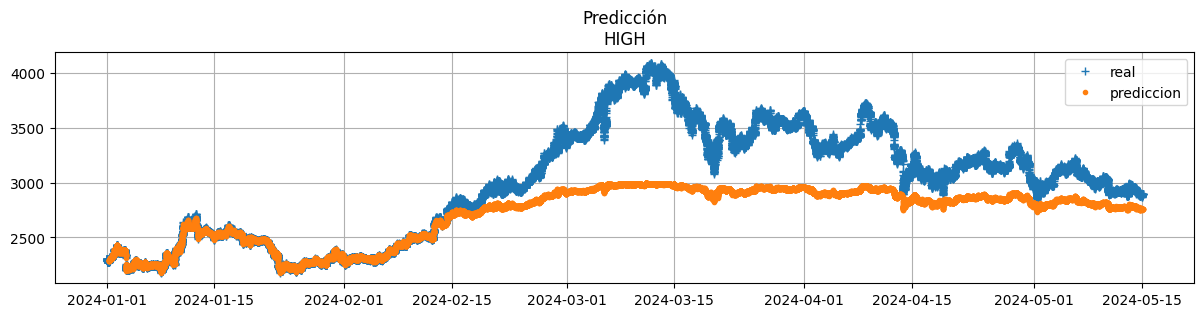

In [34]:
fig=plt.figure(figsize=(50,3))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Predicción\nHIGH")
ax1.plot( valid_ds.high, marker = '+', linewidth = 0 )
ax1.plot( df_prediccion['High'], marker = '.', linewidth = 0 )
plt.legend(['real','prediccion'])
plt.grid(True)
plt.show()

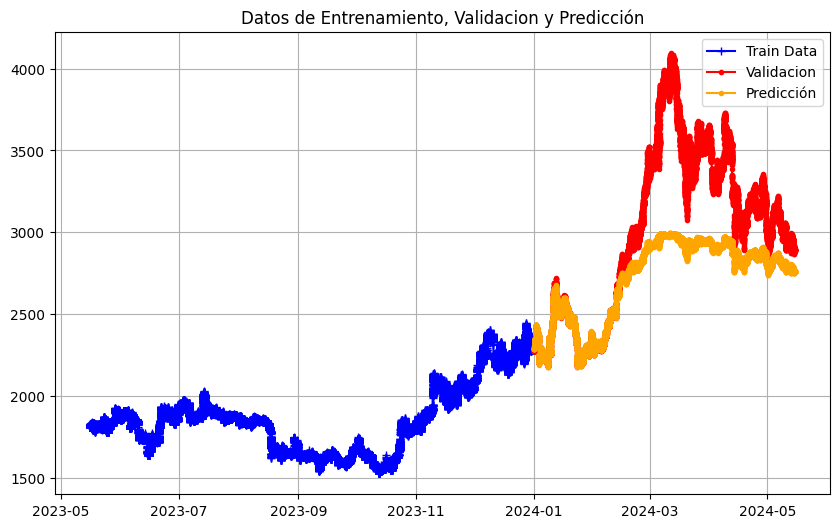

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
# Graficar los datos de train_ds
ax.plot(train_ds.index, train_ds.high, label='Train Data', marker='+', linestyle='-', color='blue')
# Graficar los datos de valid_ds
ax.plot(valid_ds.index, valid_ds.high, label='Validacion', marker='.', linestyle='-', color='red')
# Graficar los datos de df_prediccion
ax.plot(df_prediccion.index, df_prediccion['High'], label='Predicción', marker='.', linestyle='-', color='orange')

ax.set_title('Datos de Entrenamiento, Validacion y Predicción')
ax.legend()
ax.grid(True)
plt.show()

In [36]:
maximo = None
minimo_valor = None
for i in range(df_prediccion.shape[0]):
  diferencia = np.abs(valid_ds.high[i+time_step] - df_prediccion['High'][i])
  if( maximo == None ):
    maximo = diferencia
    minimo_valor = diferencia
  else:
    if diferencia  > maximo:
      maximo = diferencia
    else:
      if diferencia  < minimo_valor:
        minimo_valor = diferencia

print("La diferencia máxima es ",maximo)
print("La diferencia mínima es ",minimo_valor)

La diferencia máxima es  1104.289873046875
La diferencia mínima es  0.0002832031250363798


In [37]:
modelo.save("/content/drive/My Drive/PrediccionCriptos/modelo_final_v2.h5")